In [1]:
import os
import time
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import sys 
from pathlib import Path
sys.path.append(os.path.abspath(r"../.."))
from model.generator import Generator, Generator_Transpose
from model.discriminator import DiscriminatorResnet, DiscriminatorLinear, DiscriminatorConv
from utils_.utils import weights_init, weight_init
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## 1. 加载和预处理MNIST数据

In [2]:
from mlxtend.data import loadlocal_mnist
train_data_path = "../../../../data/MNIST/train-images.idx3-ubyte"
train_label_path = "../../../../data/MNIST/train-labels.idx1-ubyte"
test_data_path = "../../../../data/MNIST/t10k-images.idx3-ubyte"
test_label_path = "../../../../data/MNIST/t10k-labels.idx1-ubyte"

train_data,train_label = loadlocal_mnist(
    images_path = train_data_path,
    labels_path = train_label_path
)
train_data.shape,train_label.shape

((60000, 784), (60000,))

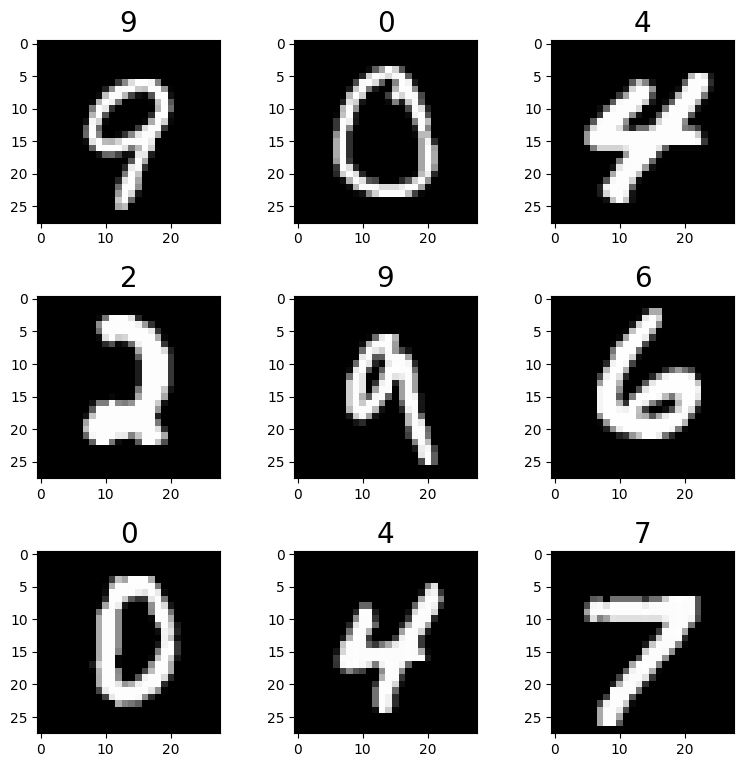

In [3]:
import matplotlib.pyplot as plt

img,ax = plt.subplots(3,3,figsize=(9,9))
plt.subplots_adjust(hspace=0.4,wspace=0.4)
for i in range(3):
    for j in range(3):
        num = np.random.randint(0,train_label.shape[0])
        ax[i][j].imshow(train_data[num].reshape((28,28)),cmap="gray")
        ax[i][j].set_title(train_label[num],fontdict={"fontsize":20})
plt.show()


## 2. Dataset and Model parameter

In [4]:
input_size = [1, 28, 28]
batch_size = 128
Epoch = 1000
GenEpoch = 1
in_channel = 64

In [5]:
from torch.utils.data import Dataset,DataLoader
import numpy as np 
from mlxtend.data import loadlocal_mnist
import torchvision.transforms as transforms

class MNIST_Dataset(Dataset):
    def __init__(self,train_data_path,train_label_path,transform=None):
        train_data,train_label = loadlocal_mnist(
            images_path = train_data_path,
            labels_path = train_label_path
            )
        self.train_data = train_data
        self.train_label = train_label.reshape(-1)
        self.transform=transform
        
    def __len__(self):
        return self.train_label.shape[0] 
    
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()
        images = self.train_data[index,:].reshape((28,28))
        labels = self.train_label[index]
        if self.transform:
            images = self.transform(images)
        return images,labels

train_data_path = "../../../../data/MNIST/train-images.idx3-ubyte"
train_label_path = "../../../../data/MNIST/train-labels.idx1-ubyte"
transform_dataset =transforms.Compose([
    transforms.ToTensor()]
)
MNIST_dataset = MNIST_Dataset(train_data_path=train_data_path,
                               train_label_path=train_label_path,
                               transform=transform_dataset)  
MNIST_dataloader = DataLoader(dataset=MNIST_dataset,
                              batch_size=batch_size,
                              shuffle=True,drop_last=False)

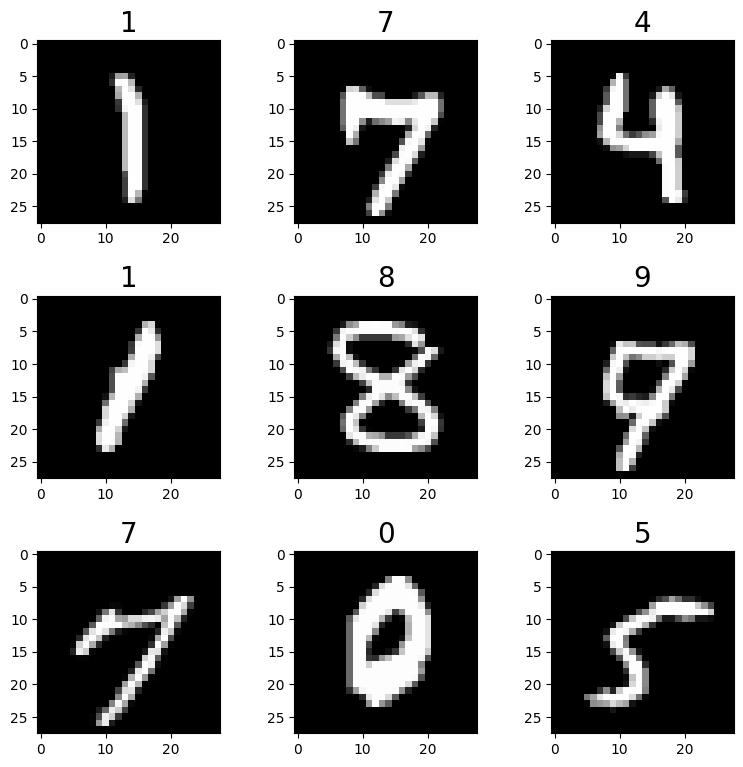

In [6]:
import matplotlib.pyplot as plt

img,ax = plt.subplots(3,3,figsize=(9,9))
plt.subplots_adjust(hspace=0.4,wspace=0.4)
for i in range(3):
    for j in range(3):
        num = np.random.randint(0,train_label.shape[0])
        ax[i][j].imshow(MNIST_dataset[num][0].reshape((28,28)),cmap="gray")
        ax[i][j].set_title(MNIST_dataset[num][1],fontdict={"fontsize":20})
plt.show()

## 3. Result save path

In [7]:
time_now = time.strftime('DCGAN_%Y-%m-%d-%H_%M_%S', time.localtime(time.time()))
log_path = f'./log/{time_now}'
os.makedirs(log_path)
os.makedirs(f'{log_path}/image')
os.makedirs(f'{log_path}/image/image_all')

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device: {device}')

using device: cuda


## 4. Model define

In [9]:
import torch
from torch import nn 

def _weight_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)
        

class Discriminator(nn.Module):
    def __init__(self,input_size,inplace=True):
        super(Discriminator,self).__init__()
        c,h,w = input_size
        self.dis = nn.Sequential(
            # b,1,28,28 -> b,64,14,14
            nn.Conv2d(c,64,(4,4),2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            
            # b,64,14,14 -> b,128,7,7
            nn.Conv2d(64,128,(4,4),2,1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            
            # b,128,7,7 -> b,256,3,3
            nn.Conv2d(128,256,(3,3),2,0,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            
            # b,128,3,3 -> b,1,1,1
            nn.Conv2d(256,1,1,3,0,bias=False),
            nn.Sigmoid()
        )
        
        
    def forward(self,x):
        x = self.dis(x)
        x = x.view(-1)
        return x 

class Generator(nn.Module):
    def __init__(self,in_channel):
        super(Generator,self).__init__() # 调用父类的构造方法
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(in_channel,1024,(3,3),1,0,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(1024,512,(3,3),2,0,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512,256,(4,4),2,1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256,1,(4,4),2,1,bias=False),
            nn.Tanh()            
        )

    def forward(self,x):
        res = self.gen(x)
        return res.view(x.size()[0],1,28,28)

D = Discriminator(input_size=input_size)
G = Generator(in_channel=in_channel)
D.apply(_weight_init)
G.apply(_weight_init)
D.to(device)
G.to(device)
D,G

(Discriminator(
   (dis): Sequential(
     (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (1): LeakyReLU(negative_slope=0.2, inplace=True)
     (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (4): LeakyReLU(negative_slope=0.2, inplace=True)
     (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
     (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): LeakyReLU(negative_slope=0.2, inplace=True)
     (8): Conv2d(256, 1, kernel_size=(1, 1), stride=(3, 3), bias=False)
     (9): Sigmoid()
   )
 ),
 Generator(
   (gen): Sequential(
     (0): ConvTranspose2d(64, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
     (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): ConvTranspose2d(102

## 6. Training

In [10]:
criterion = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(),lr=2e-4, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(),lr=2e-4, betas=(0.5, 0.999))
D.train()
G.train()
gen_loss_list = []
dis_loss_list = []

for epoch in range(Epoch):
    with tqdm(total=MNIST_dataloader.__len__(),desc=f'Epoch {epoch+1}/{Epoch}')as pbar:
        gen_loss_avg = []
        dis_loss_avg = []
        index = 0
        for batch_idx,(img,_) in enumerate(MNIST_dataloader):
            img = img.to(device)
            # the output label
            valid = torch.ones(img.size()[0]).to(device)
            fake = torch.zeros(img.size()[0]).to(device)
            # Generator input
            G_img = torch.randn([img.size()[0],in_channel,1,1],requires_grad=True).to(device)
            # ------------------Update Discriminator------------------
            # forward
            G_pred_gen = G(G_img)
            G_pred_dis = D(G_pred_gen.detach())
            R_pred_dis = D(img)
            # the misfit
            G_loss = criterion(G_pred_dis,fake)
            R_loss = criterion(R_pred_dis,valid)
            dis_loss = (G_loss+R_loss)/2
            dis_loss_avg.append(dis_loss.item())
            # backward
            D_optimizer.zero_grad()
            dis_loss.backward()
            D_optimizer.step()
            # ------------------Update Optimizer------------------
            # forward
            G_pred_gen = G(G_img)
            G_pred_dis = D(G_pred_gen)
            # the misfit
            gen_loss = criterion(G_pred_dis,valid)
            gen_loss_avg.append(gen_loss.item())
            # backward
            G_optimizer.zero_grad()
            gen_loss.backward()
            G_optimizer.step()
            # save figure
            if index % 200 == 0 or index + 1 == MNIST_dataset.__len__():
                save_image(G_pred_gen, f'{log_path}/image/image_all/epoch-{epoch}-index-{index}.png')
            index += 1
            # ------------------进度条更新------------------
            pbar.set_postfix(**{
                'gen-loss': sum(gen_loss_avg) / len(gen_loss_avg),
                'dis-loss': sum(dis_loss_avg) / len(dis_loss_avg)
            })
            pbar.update(1)
        save_image(G_pred_gen, f'{log_path}/image/epoch-{epoch}.png')
    filename = 'epoch%d-genLoss%.2f-disLoss%.2f' % (epoch, sum(gen_loss_avg) / len(gen_loss_avg), sum(dis_loss_avg) / len(dis_loss_avg))
    torch.save(G.state_dict(), f'{log_path}/{filename}-gen.pth')
    torch.save(D.state_dict(), f'{log_path}/{filename}-dis.pth')
    # 记录损失
    gen_loss_list.append(sum(gen_loss_avg) / len(gen_loss_avg))
    dis_loss_list.append(sum(dis_loss_avg) / len(dis_loss_avg))
    # 绘制损失图像并保存
    plt.figure(0)
    plt.plot(range(epoch + 1), gen_loss_list, 'r--', label='gen loss')
    plt.plot(range(epoch + 1), dis_loss_list, 'r--', label='dis loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(f'{log_path}/loss.png', dpi=300)
    plt.close(0)

Epoch 163/1000:  70%|██████▉   | 328/469 [00:17<00:07, 18.74it/s, dis-loss=0.371, gen-loss=1.77]


KeyboardInterrupt: 

## 7. predict

generator-dis: tensor([0.3375], device='cuda:0', grad_fn=<ViewBackward0>)


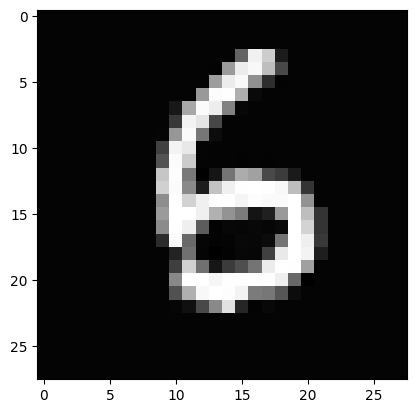

In [16]:
input_size = [1, 28, 28]
in_channel = 64
gen_para_path = './log/DCGAN_2023-02-22-16_24_04/epoch161-genLoss1.77-disLoss0.37-gen.pth'
dis_para_path = './log/DCGAN_2023-02-22-16_24_04/epoch161-genLoss1.77-disLoss0.37-dis.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen = Generator(in_channel=in_channel).to(device)
dis = Discriminator(input_size=input_size).to(device)
gen.load_state_dict(torch.load(gen_para_path, map_location=device))
gen.eval()
# 随机生成一组数据
G_img = torch.randn([1, in_channel, 1, 1], requires_grad=False).to(device)
# 放入网路
G_pred = gen(G_img)
G_dis = dis(G_pred)
print('generator-dis:', G_dis)
# 图像显示
G_pred = G_pred[0, ...].cpu().detach()
plt.figure()
plt.imshow(G_pred.reshape(28,28),cmap="gray")
plt.show()